In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
pth = os.path.join('..', '..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'modeling', 'inputs')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'preprocessing', 'modules', 'CCCA_signatures')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_in, 'CCCA_malignant.h5ad'))
adata

AnnData object with n_obs × n_vars = 1434229 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores', 'post_op_gleason_score', 'margin

In [4]:
names_plt = [
    'Data_Jerby-Arnon2018_Skin',
    'Data_Tirosh2016_Skin']

adata = adata[adata.obs.Name.isin(names_plt)].copy()
adata

AnnData object with n_obs × n_vars = 3275 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores', 'post_op_gleason_score', 'margins',

In [5]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby(
        ['Name', 'sample'], observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = src,
                          random_state = 1234)
        adata.obs.loc[msk, src] = adata_group.obs[src]

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


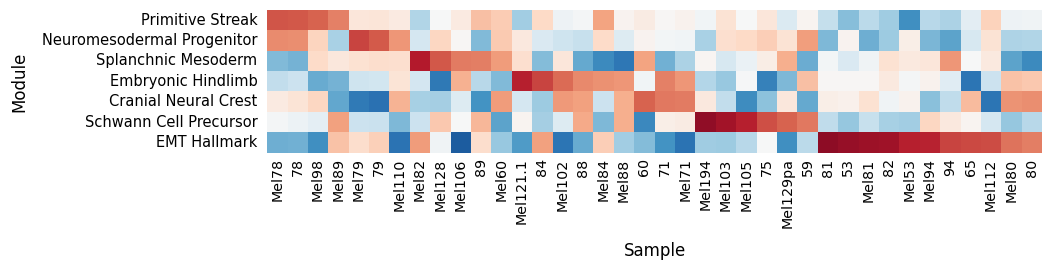

In [8]:
feat_plt = [
    'GSE162534',
    'GSE229103',
    'GSE136689',
    'HCAEmbryonicHindlimb',
    'rRNAModifications',
    'GSE201257',
    'EMTHallmark']

df_plt = (adata.obs.groupby(
          ['Name', 'sample'], observed = True)[feat_plt]
          .mean().T)
for ix in df_plt.index: df_plt.loc[ix] = zscore(df_plt.loc[ix])
for col in df_plt.columns: df_plt[col] = zscore(df_plt[col])

# select/order samples for heatmap
src, _max_ = df_plt.idxmax(), df_plt.max()
order = pd.concat({'src' : src, 'max' : _max_}, axis = 1).reset_index()
order['src'] = pd.Categorical(order.src, feat_plt, ordered = True)
order = order.sort_values(['src', 'max'], ascending = [True, False])
df_plt = df_plt.loc[:, order[['Name', 'sample']].values.tolist()]

vlim = 2.5
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
df_plt.columns = df_plt.columns.get_level_values(1)
df_plt.index = df.loc[df_plt.index].Name
hm = sns.heatmap(
    df_plt,
    cmap = 'RdBu_r',
    vmin = -vlim,
    vmax = vlim,
    square = True,
    cbar = False,
    ax = ax)

ax.set_xlabel('Sample', size = 12, labelpad = 10)
ax.set_ylabel('Module', size = 12, labelpad = 10)
ax.tick_params(size = 0, pad = 7, labelsize = 10.5)
ax.set_xticklabels(ax.get_xticklabels(),
                   size = 10.25, rotation = 90)
ax.tick_params(axis = 'x', pad = 4)
fn = os.path.join(pth_out, 'melanoma.pdf')
plt.savefig(fn, bbox_inches = 'tight')